In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import glob
import pickle
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.set_printoptions(threshold=np.inf)
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/tabea/Documents/UrbanMobility/src')
from models_ml_dl import deep_learning_model as dl_models
from visualization import model_evaluation as eval

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Preparation

In [83]:
# hourly data

journey_hourly_16 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2016.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2017.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2018.csv', parse_dates=['start_date'], index_col=0)
journey_hourly_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_hourly_2019.csv', parse_dates=['start_date'], index_col=0)

# use 2016, 2017 and 2018 as train data and 2019 as test data
journey_train_orig = pd.concat([journey_hourly_16, journey_hourly_17, journey_hourly_18])
journey_test_orig = journey_hourly_19.copy()

# remove start_data and demand column
journey_train = journey_train_orig.drop(columns=['start_date', 'demand'])
journey_test = journey_test_orig.drop(columns=['start_date', 'demand'])


In [84]:
# min max scaling

# initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# fit the scaler using the training data and transform the training and test data
journey_train_scaled = scaler.fit_transform(journey_train)
journey_test_scaled = scaler.transform(journey_test)

# convert back to DataFrame
journey_train_scaled = pd.DataFrame(journey_train_scaled, columns=journey_train.columns)
journey_test_scaled = pd.DataFrame(journey_test_scaled, columns=journey_test.columns)

# add the target feature back
journey_train_scaled['demand'] = journey_train_orig['demand'].values
journey_test_scaled['demand'] = journey_test_orig['demand'].values

In [117]:
lookback = 96
X_train, Y_train, X_test, Y_test = dl_models.create_train_test_data(journey_train_scaled, journey_test_scaled, lookback)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(313596, 96, 105) (313596,)
(103644, 96, 105) (103644,)


### LSTM

In [118]:
lstm_model = dl_models.create_lstm(X_train, units=30)
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 96, 30)            16320     
                                                                 
 lstm_10 (LSTM)              (None, 96, 30)            7320      
                                                                 
 lstm_11 (LSTM)              (None, 30)                7320      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 30,991
Trainable params: 30,991
Non-trainable params: 0
_________________________________________________________________


In [119]:
# fitting and predicting

lstm_model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

lstm_history = lstm_model.fit(X_train, Y_train, epochs = 2, batch_size = 32, 
                    validation_split= 0.2, 
                    callbacks = EarlyStopping(monitor='val_loss', patience = 5))

lstm_pred = lstm_model.predict(X_test)


Epoch 1/2
7840/7840 [==============================] - 746s 94ms/step - loss: 57.2442 - val_loss: 35.2058
Epoch 2/2
3239/3239 [==============================] - 74s 22ms/step


In [153]:
# save model and history
lstm_model.save('../models/lstm_model.h5')

with open('../models/lstm_history.pkl', 'wb') as f:
    pickle.dump(lstm_history.history, f)

In [120]:
# evaluation
mae = mean_absolute_error(Y_test, lstm_pred)
rmse = mean_squared_error(Y_test, lstm_pred, squared=False)
r_squared = r2_score(Y_test, lstm_pred)

print("MAE: ", mae )
print( "RMSE: ", rmse )
print("R2: ", r_squared)

MAE:  17.977001626145295
RMSE:  80.62272157050576
R2:  0.6602320636718455


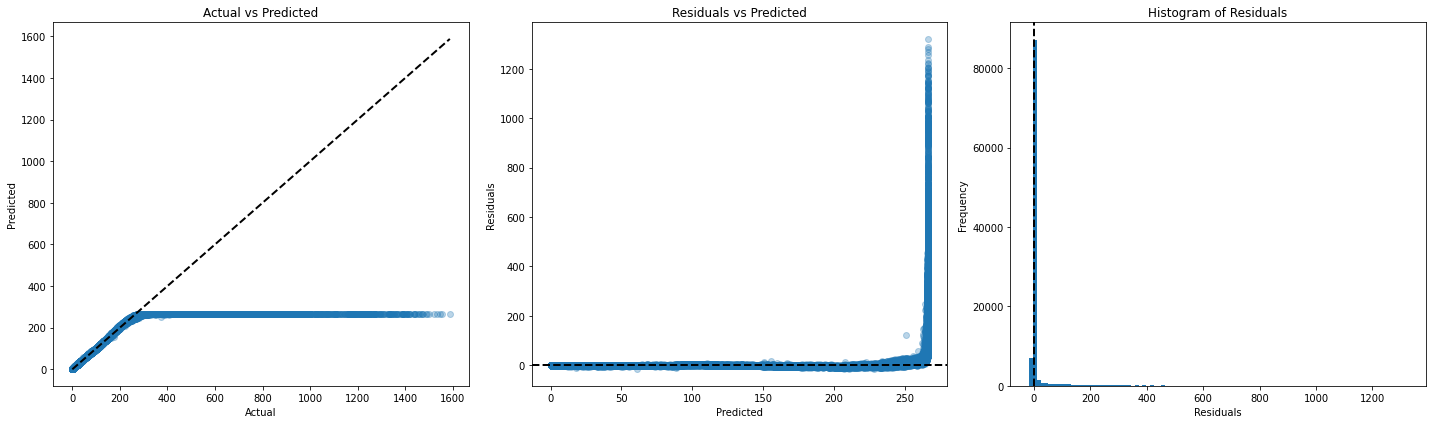

In [121]:
eval.evaluation_vis(Y_test, lstm_pred.reshape(-1))

1152


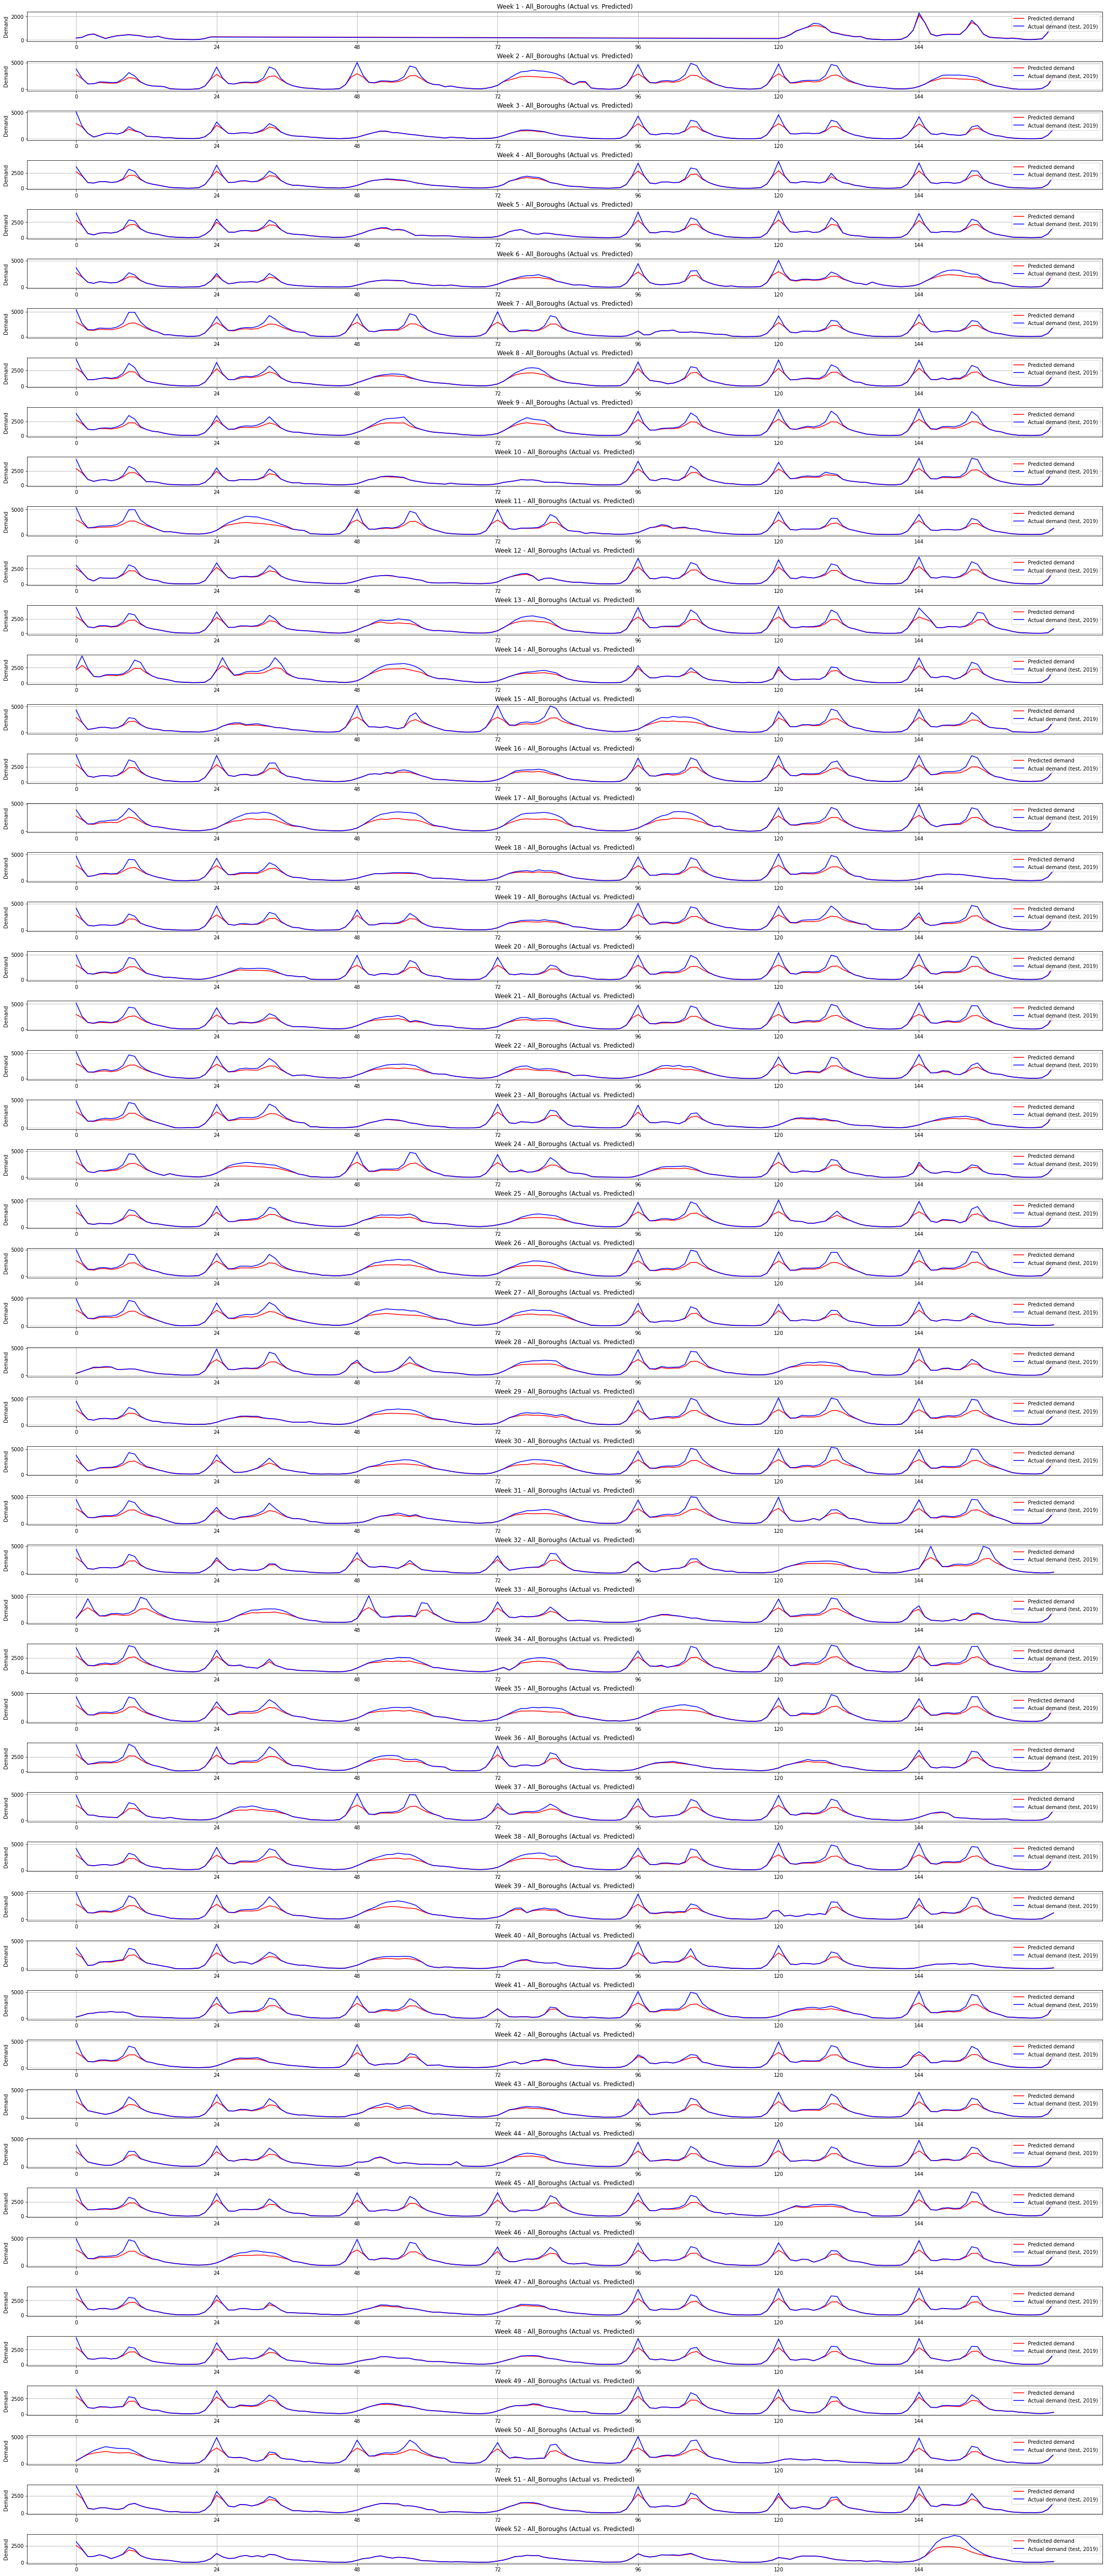

In [122]:
# visualisation: pred vs actual

num_rows_to_cut = journey_test_orig.shape[0] - Y_test.shape[0]
print(num_rows_to_cut)
journey_test_orig = journey_test_orig.iloc[num_rows_to_cut:, :]

eval.evaluation_actual_vs_predicted_hourly(Y_test, lstm_pred, journey_test_orig, 'All_Boroughs', 'model_lstm')


In [ ]:
# visualisation: pred vs actual per borough
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

for borough in boroughs:
    eval.evaluation_actual_vs_predicted_hourly(Y_test, lstm_pred, journey_test_orig, borough, 'model_lstm')

### Transformer

In [12]:
# train model
tr_model = dl_models.Transformer()
tr_model.train(X_train, Y_train, epochs=10)

# save model
tr_model.model.save('../models/tranformer_model.h5')

# predict
tr_pred = tr_model.predict(X_test)

Epoch 1/10
9800/9800 [==============================] - 19890s 2s/step - loss: 0.0493
Epoch 2/10
9800/9800 [==============================] - 15335s 2s/step - loss: 0.0189
Epoch 3/10
  20/9800 [..............................] - ETA: 1:42:15 - loss: 0.0168

KeyboardInterrupt: 

In [ ]:
# transform to original scale
tr_pred_inv, Y_test_inv = dl_models.transform_to_original_sclae(total_df, tr_pred, Y_test, input_data, scaler)

In [ ]:
# evaluation
mae = mean_absolute_error(Y_test_inv, tr_pred_inv)
rmse = mean_squared_error(Y_test_inv, tr_pred_inv, squared=False)
r_squared = r2_score(Y_test_inv, tr_pred_inv)

print("MAE: ", mae )
print( "RMSE: ", rmse )
print("R2: ", r_squared)

Evaluation
MAE:  5.987470258906309
RMSE:  22.99890016918649
R2:  0.9187948549522943


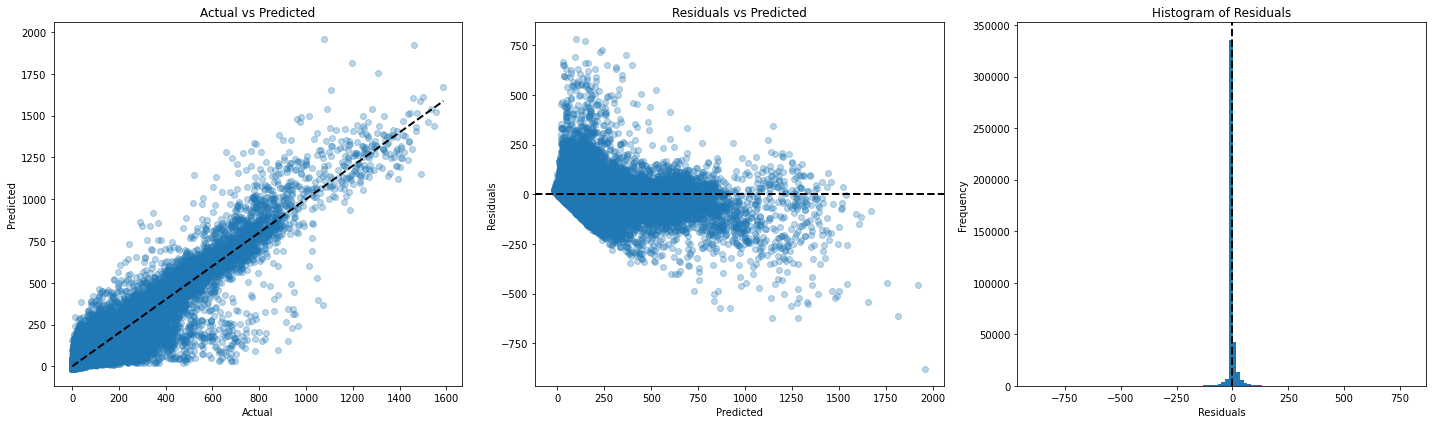

In [ ]:
# evaluation visualisation
eval.evaluation_vis(Y_test_inv, tr_pred_inv)

In [ ]:
# visualisation: pred vs actual
eval.evaluation_actual_vs_predicted(Y_test_inv, tr_pred_inv, journey_test_orig, 'All_Boroughs', 'model_transformer')

In [ ]:
# visualisation: pred vs actual per borough
boroughs = ['Westminster', 'Tower Hamlets', 'Kensington and Chelsea', 'Camden', 'Hammersmith and Fulham', 'Lambeth', 'Wandsworth', 'Southwark', 
            'Hackney', 'City of London', 'Islington', 'Newham']

for borough in boroughs:
    eval.evaluation_actual_vs_predicted_hourly(Y_test_inv, tr_pred_inv, journey_test_orig, borough, 'model_transformer')